In [ ]:
!pip install transformers -q
!pip install sentencepiece -q
!pip install editdistance -q
!pip install sacrebleu -q

     |████████████████████████████████| 3.1 MB 16.6 MB/s 
     |████████████████████████████████| 895 kB 68.0 MB/s 
     |████████████████████████████████| 596 kB 62.1 MB/s 
     |████████████████████████████████| 3.3 MB 53.6 MB/s 
     |████████████████████████████████| 61 kB 541 kB/s 
     |████████████████████████████████| 1.2 MB 13.0 MB/s 
     |████████████████████████████████| 90 kB 6.7 MB/s 


In [ ]:
# Mount Google drive to upload datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# The path to the data on my drive
D = '/content/drive/My Drive/W266_Project_Data/pmi_data'

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import editdistance
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import copy
import csv
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
% cd /content/drive/My Drive/W266_Project_Data/pmi_data/predicted_text/IndicBert_ensemble

/content/drive/My Drive/W266_Project_Data/pmi_data/predicted_text/IndicBert_ensemble


In [ ]:
%ls

combined-ma.csv                indicbert_best_ta_eval.csv
combined-ma.xlsx               original_sentence-hi.txt
combined-ta.csv                original_sentence-ma.txt
combined-ta.xlsx               original_sentence-ta.txt
indicbert_best_combined.xlsx   record_comparison_indicbert_best.csv
indicbert_best_hi_eval.csv     selected_translation-hi.txt
indicbert_best_hi_eval.gsheet  selected_translation-ma.txt
indicbert_best_ml_eval.csv     selected_translation-ta.txt


In [ ]:
# Load the combined dataframe from the IndicBert best
final = pd.read_excel("combined-ta.xlsx")
final.drop(columns=['mBART_NP_logits', 'mBART_P_logits', 'model_pred_mbart',
                    'IndicT_NP_logits', 'IndicT_P_logits', 'model_pred_IndicT',
                    'mBART_avg', 'IT_avg'
                    ], inplace=True)

In [ ]:
# Clean up columns so that they resemble those used in the Siamese notebook
final.rename(columns={'Original_Sentence': 'target_sentence', 'mBART_Translated': 'bart_translation',
                      'IndicTrans_Translated': 'indictrans_translation', 'mbart_P_prob': 'bart_paraphrase_score',
                      'mbart_NP_prob': 'bart_np_score', 'indicT_NP_prob': 'indictrans_np_score',
                      'indicT_P_prob': 'indictrans_paraphrase_score', 'selected_translation': 'best_trans'}, inplace=True)

In [ ]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def sentence_embeddings(device, tokenizer, model, sentences):
  """Create contextualized sentence embeddings
  
  Parameters:
  tokenizer: transformers tokenizer for creating word tokens
  model:
  sentences: sentences to generate sentence embeddings for
  """

  # Tokenize sentences and return PyTorch tensors
  encoded_input = tokenizer(sentences, padding=True, truncation=True, 
                            max_length=128, return_tensors='pt')
  encoded_input = encoded_input.to(device)
  
  # Pass the tokenized input to the model 
  with torch.no_grad():
    model.to(device)
    model_output = model(**encoded_input) 
  
  # Perform mean pooling to get total sentence embeddings
  sentence_embeddings = mean_pooling(model_output, 
                                     encoded_input['attention_mask'])
  
  return sentence_embeddings

In [ ]:
# Get the sentence embeddings and cosine similarity scores between each pair of sentences in the dataset
# This is to check if low scoring sentences have exact similarity scores or if they are of low quality
def check_cosine_similarity(df, device, tokenizer, model):

  # Create an empty list to check cosine similarity scores
  bart_cos_scores = []
  indictrans_cos_scores = []

  for index, rows in df.iterrows():
    # Get the sentence embeddings of each pair of target sentences
    sent1_embed = sentence_embeddings(device, tokenizer, model, rows['target_sentence'])
    sent2_embed = sentence_embeddings(device, tokenizer, model, rows['bart_translation'])
    sent3_embed = sentence_embeddings(device, tokenizer, model, rows['indictrans_translation'])

    # Reshape the embeddings to be of a single dimension 
    # Get the cosine similarity between the two pairs of sentence embeddings
    bart_cosine_similarity_value = F.cosine_similarity(sent1_embed.squeeze(0), sent2_embed.squeeze(0), dim=0)
    indictrans_cosine_similarity_value = F.cosine_similarity(sent1_embed.squeeze(0), sent3_embed.squeeze(0), dim=0)

    # Add the cosine similarity scores to their respective lists
    bart_cos_scores.append(bart_cosine_similarity_value.item())
    indictrans_cos_scores.append(indictrans_cosine_similarity_value.item())

  # Create two new columns in the dataframe to hold the respective scores
  df['bart_cosine_score'] = bart_cos_scores
  df['indictrans_cosine_score'] = indictrans_cos_scores

  return df

In [ ]:
def get_metrics(df):
  """A function that returns the dataframe with new columns for bart and indictrans cosine scores and edit distances"""

  # Set up the device to run on GPU if available
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  # Set the tokenizer and model as IndicBert Tokenizer and IndicBert model 
  tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert', keep_accents=True)
  model = AutoModel.from_pretrained('ai4bharat/indic-bert')

  # Get the cosine similarity scores for bart and indictrans
  final = check_cosine_similarity(df, device, tokenizer, model)

  # Get the edit distances for bart and indictrans
  final['indictrans_edit'] = final.apply(lambda x: editdistance.eval(x['target_sentence'], x['indictrans_translation']), axis=1)
  final['bart_edit'] = final.apply(lambda x: editdistance.eval(x['target_sentence'], x['bart_translation']), axis=1)

  return final
  

In [ ]:
# Add the new cosine similarity and edit distances score columns to the dataframe
df = get_metrics(final)

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129M [00:00<?, ?B/s]

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['sop_classifier.classifier.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.decoder.bias', 'sop_classifier.classifier.bias', 'predictions.bias', 'predictions.dense.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Add a new column for the source of the best translation
df['best_trans_source'] = np.where(df.indictrans_paraphrase_score >= df.bart_paraphrase_score , "indictrans", "mbart")

In [ ]:
# Add a new column based upon whether or not cosine similarity score went up or down
conditions = [
    (df['best_trans_source'] == 'indictrans') & (df['indictrans_cosine_score'] > df['bart_cosine_score']),
    (df['best_trans_source'] == 'indictrans') & (df['indictrans_cosine_score'] < df['bart_cosine_score']),
    (df['best_trans_source'] == 'indictrans') & (df['indictrans_cosine_score'] == df['bart_cosine_score']),
    (df['best_trans_source'] == 'mbart') & (df['bart_cosine_score'] > df['indictrans_cosine_score']),
    (df['best_trans_source'] == 'mbart') & (df['bart_cosine_score'] < df['indictrans_cosine_score']),
    (df['best_trans_source'] == 'mbart') & (df['bart_cosine_score'] == df['bart_cosine_score'])
    ]
values = ['score increased', 'score decreased', 'no change', 'score increased', 'score decreased', 'no change']

df['cos_change'] = np.select(conditions, values)

In [ ]:
# Create a scatterplot of cosine similarity scores and paraphrase probability scores
# Add a column for the best translation cosine similarity score and another for best translation paraphrase score
df['best_paraphrase_cos'] = np.where(df.best_trans_source == 'mbart', df.bart_cosine_score, df.indictrans_cosine_score)
df['best_paraphrase_para'] = np.where(df.best_trans_source == 'mbart', df.bart_paraphrase_score, df.indictrans_paraphrase_score)

In [ ]:
# The cosine similarity score of the sentence chosen by the paraphrase evaluator is higher than that of the non-chosen sentence
# the majority of the time
df.cos_change.value_counts()

score increased    559
score decreased    433
no change            8
Name: cos_change, dtype: int64

In [ ]:
# Add 2 new columns to calculate the character edit distance
# 1 between IndicTrans translation and target
# 1 for MBart translation and target
df['indictrans_edit'] = df.apply(lambda x: editdistance.eval(x['target_sentence'], x['indictrans_translation']), axis=1)
df['bart_edit'] = df.apply(lambda x: editdistance.eval(x['target_sentence'], x['bart_translation']), axis=1)

In [ ]:
# Create a new column for the difference in edit distances between the translation chosen vs not chosen
df["editd_chosen"] = np.where(df.best_trans_source == 'mbart', df.bart_edit - df.indictrans_edit, 
                              df.indictrans_edit - df.bart_edit)

In [ ]:
# Set a column for the edit distance of the translation labeled as best by our classifier
df['best_paraphrase_edit'] = np.where(df.best_trans_source == 'mbart', df.bart_edit, df.indictrans_edit)

In [ ]:
# Get the counts of the number of times that IndicBert thinks that the MBART translation is a paraphrase
# MBart is considered to have produced for Tamil ~60% of the time
print(len(df[df.bart_paraphrase_score > df.bart_np_score]))
print(len(df[df.bart_paraphrase_score < df.bart_np_score]))
print(len(df[df.bart_paraphrase_score == df.bart_np_score]))

# IndicTrans is also considered to have produced a paraphrase the majority of the time
# and slightly more often than MBART ~65% of the time
print(len(df[df.indictrans_paraphrase_score > df.indictrans_np_score]))
print(len(df[df.indictrans_paraphrase_score < df.indictrans_np_score]))
print(len(df[df.indictrans_paraphrase_score == df.indictrans_np_score]))

594
406
0
654
346
0


In [ ]:
# Check the distribution of paraphrase and NP scores by translator
p_np_scores = df[["bart_np_score", "bart_paraphrase_score", "indictrans_np_score", "indictrans_paraphrase_score"]]
p_np_scores = p_np_scores.melt(var_name='cols',  value_name='vals')

In [ ]:
# Create a list of the column labels
p_labs = [x for x in p_np_scores['cols'].unique() if "paraphrase" in x]
np_labs = [x for x in p_np_scores['cols'].unique() if "np_" in x]
print(p_labs)
print(np_labs)

['bart_paraphrase_score', 'indictrans_paraphrase_score']
['bart_np_score', 'indictrans_np_score']


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

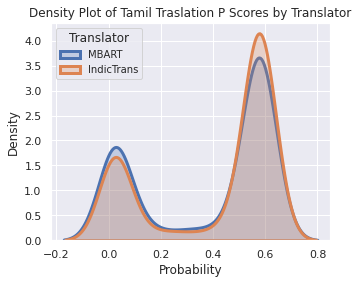

In [ ]:
# For the majority of translations, paraphrase probability scores are clustered near .6
# However, there are a number of translations from both translators with probabilities near 0
# which reflects the greater number of translations not considered paraphrases
sns.set(rc={'figure.figsize':(5,4)})
for lab in p_labs:
    # Subset to the translator
    subset = p_np_scores[p_np_scores['cols'] == lab]
    if lab == 'bart_paraphrase_score':
      lab = 'MBART'
    else:
      lab = 'IndicTrans'
    # Draw the density plot
    sns.distplot(subset['vals'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = lab)
    
# Plot formatting
plt.legend(prop={'size': 10}, title = 'Translator', loc = 'upper left')
plt.title('Density Plot of Tamil Traslation P Scores by Translator')
plt.xlabel('Probability')
plt.ylabel('Density')

In [ ]:
# Write the df file to a csv
df.to_csv(D+"/predicted_text/IndicBert_ensemble/indicbert_best_ta_eval.csv")

In [ ]:
# IndicTrans translations have a higher average probability of being a paraphrase than those of MBART
print(df.indictrans_paraphrase_score.mean())
print(df.bart_paraphrase_score.mean())

# Check the mean paraphrase probability scores for sentences considered paraphrases
# The average score for translations considered paraphrases is near .6
print(df.loc[df.indictrans_paraphrase_score >= .5].indictrans_paraphrase_score.mean())
print(df.loc[df.bart_paraphrase_score >= .5].bart_paraphrase_score.mean())

0.4126350139024279
0.3850872369518833
0.5770716036981732
0.5766066814415088


In [ ]:
# Create sub dataframes for each translator when it was chosen as the best translation
indic_chosen = df[df.best_trans_source == 'indictrans']
mbart_chosen = df[df.best_trans_source == 'mbart']

In [ ]:
# The direct IndicBert model chooses an IndicTrans translation more often than an MBART one
print(len(mbart_chosen))
print(len(indic_chosen))

444
556


In [ ]:
# When Indictrans was chosen as the translation, the cosine similarity score decreases more often than it increases
indic_chosen.cos_change.value_counts()

score decreased    292
score increased    256
no change            8
Name: cos_change, dtype: int64

In [ ]:
# When MBart is chosen as the translation, the cosine similarity scores increase more often than they decrease
mbart_chosen.cos_change.value_counts()

score increased    303
score decreased    141
Name: cos_change, dtype: int64

In [ ]:
# When IndicTrans is chosen as the translator, the edit distance is lower than the MBART translation more often than it is higher
print(len(indic_chosen[indic_chosen.editd_chosen < 0]))
print(len(indic_chosen[indic_chosen.editd_chosen > 0]))
print(len(indic_chosen[indic_chosen.editd_chosen == 0]))

374
151
31


In [ ]:
# When MBART is chosen as the translator, the edit distance is lower than the IndicTrans translation
# more often than it is higher
print(len(mbart_chosen[mbart_chosen.editd_chosen < 0]))
print(len(mbart_chosen[mbart_chosen.editd_chosen > 0]))
print(len(mbart_chosen[mbart_chosen.editd_chosen == 0]))

263
164
17


In [ ]:
# Overall, the edit distance is usually higher than the translation not chosen
print(len(indic_chosen[indic_chosen.editd_chosen < 0]) + len(mbart_chosen[mbart_chosen.editd_chosen < 0]))
print(len(indic_chosen[indic_chosen.editd_chosen > 0]) + len(mbart_chosen[mbart_chosen.editd_chosen > 0]))
print(len(indic_chosen[indic_chosen.editd_chosen == 0]) + len(mbart_chosen[mbart_chosen.editd_chosen == 0]))

637
315
48
